Searching for sync certificate: /home/albert/git/DSA2000-Cal/dsa2000_cal/src/dsa2000_assets/arrays/dsa2000_optimal_v1/.sync_cert
=== (dsa2000_common.delay_models.base_far_field_delay_engine) _compute_visibility_coords ===
In: ([T,...],[B,...],[B,...]) Out: ([T,B,...])
vmap(T, in_axes=(0, None, None), out_axes=0)  # -> In: ([...],[B,...],[B,...]) Out: ([B,...])
vmap(B, in_axes=(None, 0, 0), out_axes=0)  # -> In: ([...],[...],[...]) Out: ([...])
Implied function signature :: (...),(...),(...) -> (...)


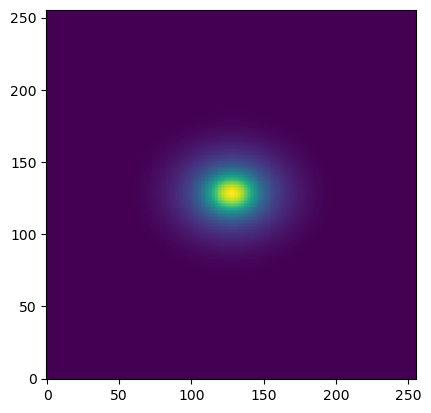

3.8129083607947107 3.0035357222187673 1.5690013969086634
dl=0.25 arcsec, dm=0.25 arcsec, major=3.817590171642891, minor=3.016184571021022, pos_angle=1.5727466468634885, error=0
dl=0.25 arcsec, dm=0.25 arcsec, major=3.8310003604949547, minor=2.9985986400098197, pos_angle=1.570796326793217, error=0.01348750269102634
dl=0.25 arcsec, dm=0.25 arcsec, major=3.8070168821808683, minor=2.998029223223226, pos_angle=1.5707963267948961, error=0.03224104192743481
dl=0.25 arcsec, dm=0.25 arcsec, major=3.810426847083938, minor=3.006319409806108, pos_angle=1.5720985586221037, error=0.04030522517468697
dl=0.25 arcsec, dm=0.25 arcsec, major=3.8109117073194247, minor=3.0263282224191017, pos_angle=1.5722924140589394, error=0.044034410994764725
dl=0.25 arcsec, dm=0.25 arcsec, major=3.8141632259030938, minor=3.007920513618349, pos_angle=1.5745431755318826, error=0.066914198810272
dl=0.25 arcsec, dm=0.25 arcsec, major=3.8180723115518354, minor=2.9786502173187275, pos_angle=1.5745312881130173, error=0.0714750

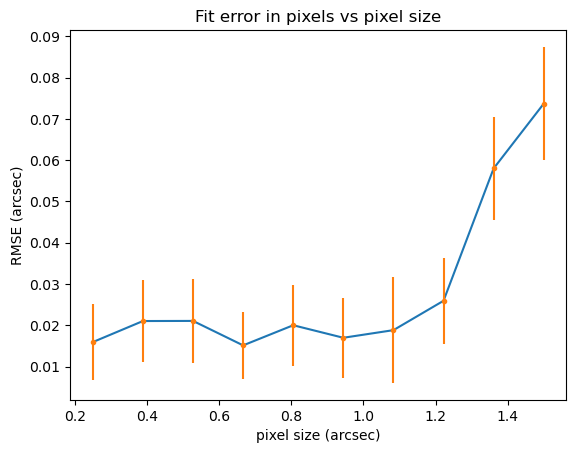

In [2]:

import astropy.coordinates as ac
import astropy.time as at
import astropy.units as au
import numpy as np
import pylab as plt

from dsa2000_assets.content_registry import fill_registries
from dsa2000_assets.registries import array_registry
from dsa2000_common.common.enu_frame import ENU
from dsa2000_common.common.noise import calc_baseline_noise
from dsa2000_common.common.quantity_utils import quantity_to_jnp, time_to_jnp, quantity_to_np
from dsa2000_common.common.wgridder import vis_to_image_np
from dsa2000_common.delay_models.base_far_field_delay_engine import build_far_field_delay_engine
from dsa2000_common.delay_models.base_near_field_delay_engine import build_near_field_delay_engine
from dsa2000_common.geodesics.base_geodesic_model import build_geodesic_model
from dsa2000_fm.imaging.base_imagor import fit_beam

num_time = 1

fill_registries()
array = array_registry.get_instance(array_registry.get_match('dsa2000_optimal_v1'))
array_location = array.get_array_location()
ref_time = at.Time('2021-01-01T00:00:00', scale='utc')
obstimes = ref_time + array.get_integration_time() * np.arange(num_time)
phase_center = ENU(0, 0, 1, location=array_location, obstime=ref_time).transform_to(ac.ICRS())
obsfreqs = array.get_channels()[[0, len(array.get_channels()) // 2, -1]]
freqs = quantity_to_np(obsfreqs, 'Hz')
times = np.array(time_to_jnp(obstimes, ref_time))

noise = calc_baseline_noise(
    quantity_to_jnp(array.get_system_equivalent_flux_density(), 'Jy'),
    chan_width_hz=1300e6 / 10000,
    t_int_s=1.5
)

pointing = phase_center
antennas = array.get_antennas()

geodesic_model = build_geodesic_model(
    antennas=antennas,
    array_location=array_location,
    phase_center=phase_center,
    obstimes=obstimes,
    ref_time=ref_time,
    pointings=pointing
)

far_field_delay_engine = build_far_field_delay_engine(
    antennas=antennas,
    phase_center=phase_center,
    start_time=obstimes.min(),
    end_time=obstimes.max(),
    ref_time=ref_time
)

near_field_delay_engine = build_near_field_delay_engine(
    antennas=antennas,
    start_time=obstimes.min(),
    end_time=obstimes.max(),
    ref_time=ref_time
)

visibility_coords = far_field_delay_engine.compute_visibility_coords(
    freqs=freqs,
    times=times,
    with_autocorr=False
)

uvw = np.array(visibility_coords.uvw.reshape((-1, 3)))
vis = np.ones(uvw.shape[:1] + np.shape(freqs), np.complex64)

dl = dm = 0.1 * au.arcsec
psf = vis_to_image_np(
    uvw=uvw, freqs=freqs, vis=vis,
    pixsize_l=quantity_to_np(dl, 'rad'),
    pixsize_m=quantity_to_np(dm, 'rad'),
    center_l=0., center_m=0., npix_l=256, npix_m=256,
    num_threads=1
)
plt.imshow(psf.T, origin='lower', interpolation='none')
plt.show()
true_major_fwhm, true_minor_fwhm, true_pos_angle = fit_beam(psf, quantity_to_jnp(dl, 'rad'),
                                                            quantity_to_jnp(dm, 'rad'))
print(true_major_fwhm * 180 / np.pi * 3600, true_minor_fwhm * 180 / np.pi * 3600, true_pos_angle)

x = []
y = []
yerr = []
for pixsize in np.linspace(0.25, 1.5, 10):
    dl = dm = pixsize * au.arcsec
    error = 0
    error2 = 0
    for _ in range(30):
        psf = vis_to_image_np(
            uvw=uvw, freqs=freqs,
            vis=vis * np.exp(1j * (2 / 57) * np.random.normal(size=vis.shape)) + (noise / np.sqrt(2)) * (
                        np.random.normal(size=vis.shape) + 1j * np.random.normal(size=vis.shape)),
            pixsize_l=quantity_to_np(dl, 'rad'),
            pixsize_m=quantity_to_np(dm, 'rad'),
            center_l=0., center_m=0., npix_l=256, npix_m=256,
            num_threads=1
        )
        # plt.imshow(psf.T, origin='lower', interpolation='none')
        # plt.show()
        major, minor, pos_angle = fit_beam(psf, quantity_to_jnp(dl, 'rad'), quantity_to_jnp(dm, 'rad'))
        _error = np.minimum(np.sqrt(((major - true_major_fwhm) ** 2 + (minor - true_minor_fwhm) ** 2)),
                            np.sqrt(
                                ((major - true_minor_fwhm) ** 2 + (minor - true_major_fwhm) ** 2))) * 180 / np.pi * 3600
        print(
            f"dl={dl}, dm={dm}, major={major * 180 / np.pi * 3600}, minor={minor * 180 / np.pi * 3600}, pos_angle={pos_angle}, error={error}")
        error += _error
        error2 += _error ** 2

    error /= 30
    error2 /= 30
    error_std = np.sqrt(error2 - error ** 2)

    x.append(quantity_to_jnp(dl, 'arcsec'))
    y.append(error)
    yerr.append(error_std)
plt.plot(x, y)
plt.errorbar(x, y, yerr=yerr, fmt='.')
plt.xlabel('pixel size (arcsec)')
plt.ylabel('RMSE (arcsec)')
plt.title("Fit error in pixels vs pixel size")
plt.show()

